# Processing

Импорт и парсинг CSV

In [1]:
from pathlib import Path
from scripts.utils import parse_hgvs_file

input_csv = Path('/home/nikolenko/work/mipt/EvolvePro/data/dms/activity/ube2i.csv')
output_file = parse_hgvs_file(input_csv)

Save to /home/nikolenko/work/mipt/EvolvePro/data/dms/activity/ube2i_parsed.csv


Обработка датасета 

Cutoff values: [0.3]
Number above cutoff: [1643]
Fractions above cutoff: [0.543859649122807]
Process dataset done! [0.543859649122807]


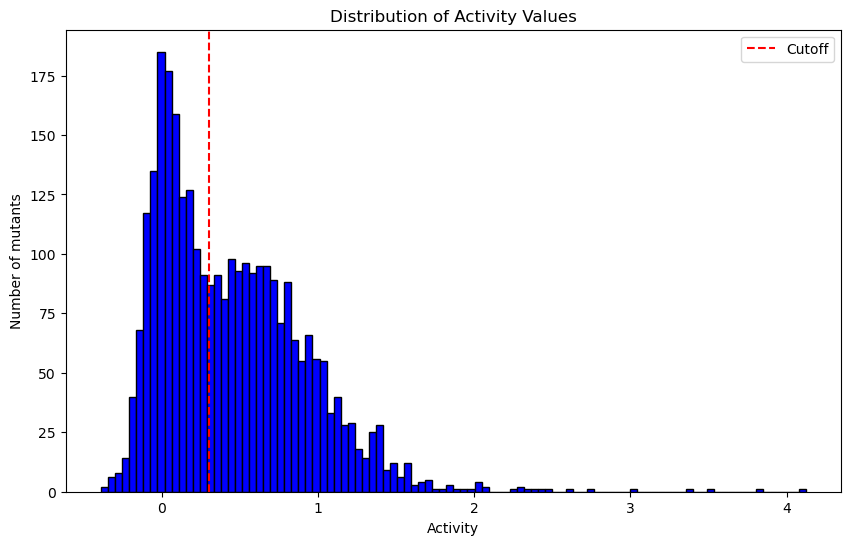

In [2]:
from evolvepro.src.process import process_dataset
import matplotlib.pyplot as plt

parsed_csv = '/home/nikolenko/work/mipt/EvolvePro/data/dms/activity/ube2i_parsed.csv'
wt_fasta = '/home/nikolenko/work/mipt/EvolvePro/data/dms/wt_fasta/ube2i_WT.fasta'
out_dir = '/home/nikolenko/work/mipt/EvolvePro/data/output/ube2i'

df, frac = process_dataset(
    file_path=parsed_csv,          
    dataset_name='ube2i',          
    wt_fasta_path=wt_fasta,       
    activity_column='Activity',    
    cutoff_value=0.3,
    output_dir=out_dir,
    sheet_name=None,
    cutoff_rule='greater_than',
    drop_columns=False
)

print("Process dataset done!", frac)



plt.figure(figsize=(10, 6))
plt.hist(df['Activity'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Activity')
plt.ylabel('Number of mutants')
plt.title('Distribution of Activity Values')
plt.axvline(x=0.3, color='red', linestyle='--', label='Cutoff')
plt.legend()
plt.show()


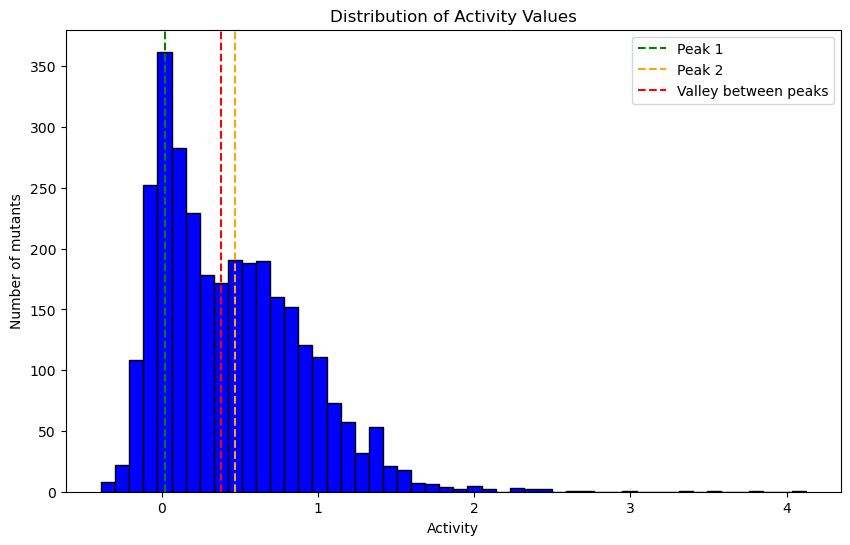

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

data = df['Activity'].dropna()

counts, bin_edges = np.histogram(data, bins=50)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

peak_indices, _ = find_peaks(counts)
valley_indices, _ = find_peaks(-counts)

peak_heights = counts[peak_indices]
peak_sorted_idx = np.argsort(peak_heights)[::-1]
p1, p2 = peak_indices[peak_sorted_idx[:2]]

start, end = min(p1, p2), max(p1, p2)
valleys_between = [v for v in valley_indices if start < v < end]

if valleys_between:
    best_valley = valleys_between[np.argmin(counts[valleys_between])]
    valley_x = bin_centers[best_valley]
else:
    valley_x = None

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]),
        color='blue', edgecolor='black', align='center')
plt.xlabel('Activity')
plt.ylabel('Number of mutants')
plt.title('Distribution of Activity Values')

plt.axvline(bin_centers[p1], color='green', linestyle='--', label='Peak 1')
plt.axvline(bin_centers[p2], color='orange', linestyle='--', label='Peak 2')
if valley_x is not None:
    plt.axvline(valley_x, color='red', linestyle='--', label='Valley between peaks')

plt.legend()
plt.show()


In [3]:
import pandas as pd
from pathlib import Path
from scripts.utils import read_fasta_as_dict

csv_path = Path("/home/nikolenko/work/mipt/EvolvePro/data/output/ube2i/ube2i_labels.csv")
fasta_path = Path("/home/nikolenko/work/mipt/EvolvePro/data/output/ube2i/ube2i.fasta")

df_labels = pd.read_csv(csv_path)

variant2seq = read_fasta_as_dict(fasta_path)

df_labels["full_seq"] = df_labels["variant"].map(variant2seq)
df_labels.dropna(subset=["full_seq"], inplace=True)

print(len(variant2seq), "mutant sequences read from fasta.")
display(df_labels.head(3))

3021 mutant sequences read from fasta.


,Position,WT_Residue,Mut_Residue,Activity,variant,activity,activity_scaled,activity_binary,full_seq
0,73,P,Q,-0.026176,P73Q,-0.026176,0.080156,0,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
1,137,Y,V,-0.115652,Y137V,-0.115652,0.060317,0,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
2,27,V,D,-0.063647,V27D,-0.063647,0.071848,0,MSGIALSRLAQERKAWRKDHPFGFVADPTKNPDGTMNLMNWECAIP...


# Считаем ESM

In [8]:
!CUDA_VISIBLE_DEVICES=4 ~/miniforge/envs/plm/bin/python ../evolvepro/plm/esm/extract.py esm2_t36_3B_UR50D ../data/output/ube2i/ube2i.fasta ../data/output/ube2i/embeddings/markin_esm2_t36_3B_UR50D --toks_per_batch 3 --include mean --concatenate_dir ../data/output/ube2i/embeddings

Transferred model to GPU
Read ../data/output/ube2i/ube2i.fasta with 3021 sequences
Processing 1 of 3021 batches (1 sequences)
Device: cuda:0
Processing 2 of 3021 batches (1 sequences)
Device: cuda:0
Processing 3 of 3021 batches (1 sequences)
Device: cuda:0
Processing 4 of 3021 batches (1 sequences)
Device: cuda:0
Processing 5 of 3021 batches (1 sequences)
Device: cuda:0
Processing 6 of 3021 batches (1 sequences)
Device: cuda:0
Processing 7 of 3021 batches (1 sequences)
Device: cuda:0
Processing 8 of 3021 batches (1 sequences)
Device: cuda:0
Processing 9 of 3021 batches (1 sequences)
Device: cuda:0
Processing 10 of 3021 batches (1 sequences)
Device: cuda:0
Processing 11 of 3021 batches (1 sequences)
Device: cuda:0
Processing 12 of 3021 batches (1 sequences)
Device: cuda:0
Processing 13 of 3021 batches (1 sequences)
Device: cuda:0
Processing 14 of 3021 batches (1 sequences)
Device: cuda:0
Processing 15 of 3021 batches (1 sequences)
Device: cuda:0
Processing 16 of 3021 batches (1 sequence

In [9]:
import pandas as pd

df_labels = pd.read_csv("../data/output/ube2i/ube2i_labels.csv")

df_embeddings = pd.read_csv("../data/output/ube2i/embeddings/ube2i_esm2_t36_3B_UR50D.csv", index_col=0)

common_variants = set(df_labels['variant']).intersection(df_embeddings.index)
df_labels = df_labels[df_labels['variant'].isin(common_variants)].copy()
df_embeddings = df_embeddings.loc[list(common_variants)].copy()

df_labels = df_labels.sort_values(by="variant").reset_index(drop=True)
df_embeddings = df_embeddings.loc[df_labels["variant"]]

In [11]:
df_labels

,Position,WT_Residue,Mut_Residue,Activity,variant,activity,activity_scaled,activity_binary
0,106,A,C,0.564008,A106C,0.564008,0.211016,1
1,106,A,D,0.055145,A106D,0.055145,0.098187,0
2,106,A,E,0.112247,A106E,0.112247,0.110848,0
3,106,A,F,-0.057903,A106F,-0.057903,0.073121,0
4,106,A,G,0.691362,A106G,0.691362,0.239253,1
...,...,...,...,...,...,...,...,...
3016,87,Y,R,-0.060169,Y87R,-0.060169,0.072619,0
3017,87,Y,S,-0.072106,Y87S,-0.072106,0.069972,0
3018,87,Y,T,0.158993,Y87T,0.158993,0.121213,0
3019,87,Y,V,0.283401,Y87V,0.283401,0.148798,0


In [10]:
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559
A106C,-0.022277,0.004915,-0.072860,-0.003199,-0.047298,0.014309,-0.067469,0.033179,0.061972,-0.036770,...,0.084227,-0.039576,0.002541,0.036450,0.085772,-0.008776,0.003003,0.059011,-0.079439,-0.003164
A106D,-0.022460,0.001864,-0.081088,-0.001586,-0.048670,0.011884,-0.066806,0.032914,0.062164,-0.037159,...,0.080157,-0.041782,0.004087,0.037906,0.083763,-0.010247,0.002781,0.059760,-0.081081,-0.001844
A106E,-0.023579,0.002933,-0.080407,-0.001708,-0.048968,0.010980,-0.065958,0.034628,0.060709,-0.037491,...,0.079170,-0.040567,0.002745,0.037303,0.081596,-0.009391,0.002604,0.062161,-0.083442,-0.002340
A106F,-0.021818,0.005486,-0.075436,-0.002137,-0.043814,0.015467,-0.068205,0.033942,0.061566,-0.035722,...,0.080864,-0.039225,0.000303,0.038805,0.085796,-0.009315,0.000588,0.058144,-0.078448,-0.004774
A106G,-0.021135,0.001302,-0.080015,-0.000666,-0.048942,0.008136,-0.070300,0.026761,0.060044,-0.038048,...,0.081514,-0.043859,0.002992,0.039277,0.085774,-0.012800,0.001664,0.059827,-0.081495,-0.002680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y87R,-0.022984,0.000642,-0.072674,-0.002067,-0.042827,0.015967,-0.068410,0.030673,0.063704,-0.031088,...,0.081968,-0.041569,0.002766,0.035580,0.086064,-0.007402,0.005676,0.054403,-0.080723,0.000339
Y87S,-0.017870,-0.001259,-0.067876,-0.002294,-0.047070,0.015537,-0.069501,0.027929,0.067398,-0.032518,...,0.080874,-0.044037,0.004019,0.038795,0.081002,-0.005048,0.006011,0.058454,-0.082250,0.000780
Y87T,-0.019121,-0.001160,-0.068976,-0.002222,-0.046146,0.016808,-0.067429,0.030795,0.065166,-0.031269,...,0.079254,-0.041738,0.002966,0.039225,0.080772,-0.005747,0.001562,0.059461,-0.082431,0.002477
Y87V,-0.020059,-0.002910,-0.069017,-0.005024,-0.046167,0.018632,-0.066767,0.029060,0.065707,-0.031828,...,0.079998,-0.042261,0.001913,0.037842,0.082841,-0.005239,0.000746,0.057352,-0.080074,0.003395


In [15]:
from scripts.dms.dms_main import grid_search

# Random
grid_search(
    dataset_name='ube2i',
    experiment_name='random_start_ube2i',
    model_name='esm2_t36_3B_UR50D',
    embeddings_path='../data/output/ube2i/embeddings',
    labels_path='../data/output/ube2i',
    num_simulations=3,
    num_iterations=[10],
    measured_var=['activity'],
    learning_strategies=['topn'],
    num_mutants_per_round=[16],
    num_final_round_mutants=16,
    first_round_strategies=['random'],
    embedding_types=['embeddings'],
    pca_components=None,
    regression_types=['randomforest'],
    embeddings_file_type='csv',
    output_dir='../data/output/ube2i/dms_results_ube2i',
    embeddings_type_pt=None,
)

Embeddings and labels are aligned
Total combinations: 1
Starting labels length: 3021
Starting non-wt length: 3021
iterations considered:    variant  iteration
0      M1L          0
1    L113K          0
2    N121W          0
3    R149V          0
4    N121H          0
5    D100N          0
6     K76R          0
7     P69T          0
8     S71K          0
9     F77T          0
10   A129K          0
11    N31I          0
12    F24M          0
13    E98Q          0
14     G3A          0
15    F82R          0
16      WT          0
(3005,)
iterations considered:    variant  iteration
0    D100S          1
1    D100C          1
2    D100Q          1
3    D100A          1
4    D100I          1
5    D100M          1
6    D102C          1
7    D100T          1
8    D100V          1
9      S2G          1
10   D100L          1
11     I4W          1
12   D102R          1
13   D100F          1
14    D66E          1
15   D100H          1
16     M1L          0
17   L113K          0
18   N121W        

Saved figure: data/output/ube2i/dms_plots_ube2i/ube2i_compare_activity_binary.png
Saved figure: data/output/ube2i/dms_plots_ube2i/ube2i_compare_median_activity.png
Saved figure: data/output/ube2i/dms_plots_ube2i/ube2i_compare_top_activity.png


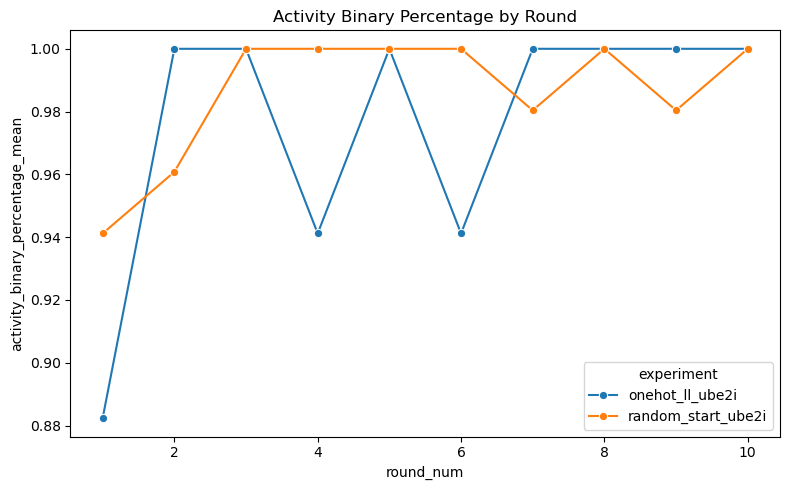

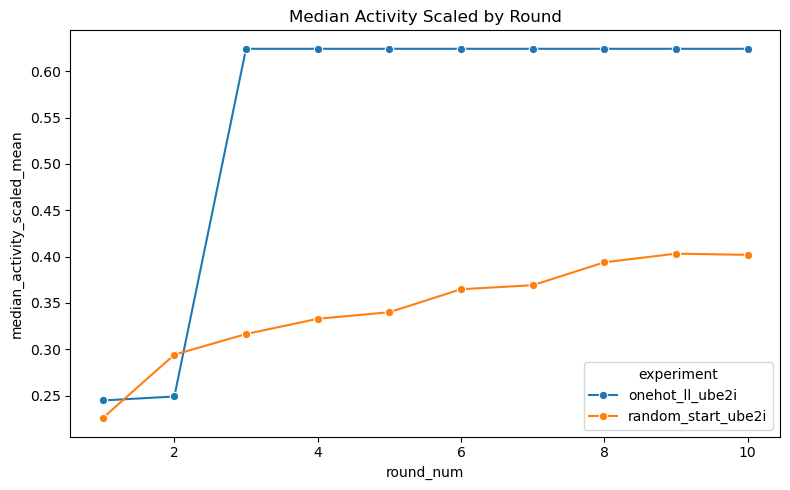

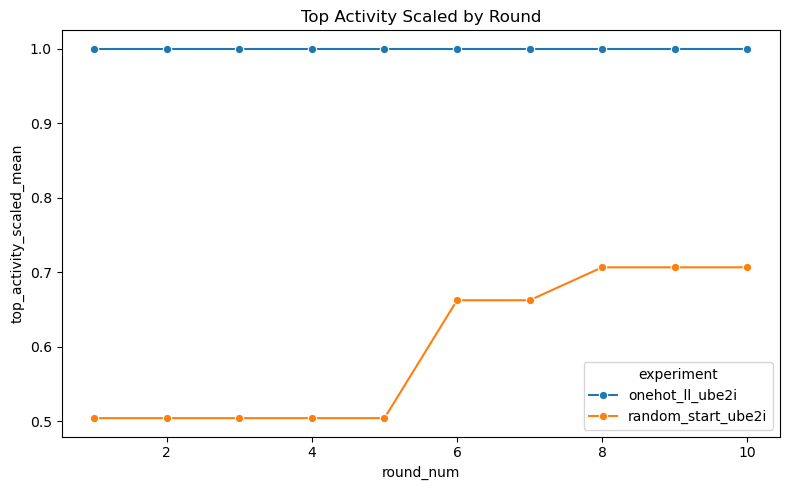

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_experiment_csv(file_path, dataset_name, experiment_name):
    df = pd.read_csv(file_path)
    df["dataset"] = dataset_name
    df["experiment"] = experiment_name
    return df

def aggregate_by_experiment_and_round(df, group_cols=("experiment", "round_num"), agg_cols=("activity_binary_percentage", "median_activity_scaled", "top_activity_scaled")):
    df = df.replace("None", pd.NA)
    for col in agg_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    grouped = df.groupby(list(group_cols))[list(agg_cols)].mean()
    df_agg = grouped.reset_index()
    df_agg.rename(columns={"activity_binary_percentage": "activity_binary_percentage_mean", "median_activity_scaled": "median_activity_scaled_mean", "top_activity_scaled": "top_activity_scaled_mean"}, inplace=True)
    return df_agg

def plot_line_by_round(df, x_col, y_col, hue_col="experiment", title="", output_dir=".", output_file=""):
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x=x_col, y=y_col, hue=hue_col, marker="o")
    plt.title(title)
    plt.tight_layout()
    if output_file:
        os.makedirs(output_dir, exist_ok=True)
        save_path = os.path.join(output_dir, output_file)
        plt.savefig(save_path, dpi=300)
        print(f"Saved figure: {save_path}")
    else:
        plt.show()

def main():
    data_dir = "data/output/ube2i/dms_results_ube2i"
    output_dir = "data/output/ube2i/dms_plots_ube2i"
    csv_onehot = os.path.join(data_dir, "ube2i_esm2_t36_3B_UR50D_onehot_ll_ube2i.csv")
    csv_random = os.path.join(data_dir, "ube2i_esm2_t36_3B_UR50D_random_start_ube2i.csv")
    df_onehot = load_experiment_csv(csv_onehot, "ube2i", "onehot_ll_ube2i")
    df_random = load_experiment_csv(csv_random, "ube2i", "random_start_ube2i")
    df_all = pd.concat([df_onehot, df_random], ignore_index=True)
    df_agg = aggregate_by_experiment_and_round(df_all)
    plot_line_by_round(df_agg, "round_num", "activity_binary_percentage_mean", "experiment", "Activity Binary Percentage by Round", output_dir, "ube2i_compare_activity_binary.png")
    plot_line_by_round(df_agg, "round_num", "median_activity_scaled_mean", "experiment", "Median Activity Scaled by Round", output_dir, "ube2i_compare_median_activity.png")
    plot_line_by_round(df_agg, "round_num", "top_activity_scaled_mean", "experiment", "Top Activity Scaled by Round", output_dir, "ube2i_compare_top_activity.png")

if __name__ == "__main__":
    main()
